In [32]:
import numpy as np
from collections import Counter, defaultdict
from scipy.sparse import csc_matrix, save_npz, load_npz
from itertools import combinations
import matplotlib.pyplot as plt
import json
import random

In [ ]:
# read .ped
individuals = set()
with open('../../DATA/ancestry/ancestry.ped', 'r') as f:
    next(f) # skip header
    for line in f:
        individuals.add(line.strip().split()[1])
        individuals.add(line.strip().split()[2])
        individuals.add(line.strip().split()[3])
individuals = sorted(individuals)
individual_to_index = dict([(x, i) for i, x in enumerate(individuals)])
print('individuals', len(individuals))

In [ ]:
# pull positions
positions = []
with open('../data/Ancestry Data files/%s.txt' % individuals[0], 'r') as f:
    line = next(f)
    while line.startswith('#'):
        line = next(f)
    for line in f:
        pieces = line.strip().split('\t')
        positions.append((int(pieces[1]), int(pieces[2])))
        
# remove positions that occur multiple times (CNV probes)
positions = sorted([k for k, v in Counter(positions).items() if v==1])
print('positions', len(positions))



In [ ]:
# pull reference at these positions
chrom_to_int = dict([('chr%d' % d, d) for d in range(1, 23)])
chrom_to_int['chrX'] = 23

chrom = None
pos_to_ref = dict()
with open('../data/hg19.fa', 'r') as f:
    for line in f:
        if line.startswith('>'):
            if chrom is not None:
                for p in pos:
                    assert (chrom_to_int[chrom], p) in pos_to_ref
            
            # pull out data
            chrom = line.strip()[1:]
            pos = [] if chrom not in chrom_to_int else [x[1] for x in positions if x[0] == chrom_to_int[chrom]]
            pos_index = 0
            current_pos = 1
            print(chrom, len(pos))
        else:
            line = line.strip()
            if pos_index == len(pos):
                # we're done with positions for this chromosome
                pass
            elif current_pos + len(line) <= pos[pos_index]:
                # no positions of interest here
                pass
            else:
                while pos_index < len(pos) and pos[pos_index]-current_pos < len(line):
                    pos_to_ref[(chrom_to_int[chrom], pos[pos_index])] = line[pos[pos_index]-current_pos]
                    pos_index += 1
            current_pos += len(line)
                


In [ ]:
print(len(individuals))

In [ ]:
ns = {'A', 'C', 'G', 'T'}
def find_genotype(ref, allele1, allele2):
    if allele1 in ns and allele2 in ns and ref in ns:
        return (allele1 != ref) + (allele2 != ref)
    return -1

for chrom, chrom_int in chrom_to_int.items():
    if chrom != 'chrX':
        print(chrom)
        poss = [x[1] for x in positions if x[0] == chrom_int]
        pos_to_index = dict([(x, i) for i, x in enumerate(poss)])
        coordinates = np.zeros((len(poss), 4), dtype=int)
        coordinates[:, 0] = chrom_int
        coordinates[:, 1] = poss
        coordinates[:, 2:] = 1


        gen = -np.ones((len(individuals), len(poss)), dtype=np.int8)
        for i, individual in enumerate(individuals):
            print(individual, end=' ')
            try:
                with open('../data/Ancestry Data files/%s.txt' % individual, 'r') as f:
                    line = next(f)
                    while line.startswith('#'):
                        line = next(f)
                    for line in f:
                        pieces = line.strip().split('\t')
                        if len(pieces) >= 5:
                            pos = int(pieces[2])
                            if int(pieces[1]) == chrom_int and pos in pos_to_index:
                                ref = pos_to_ref[(chrom_int, pos)].upper()
                                gen[i, pos_to_index[pos]] = find_genotype(ref, pieces[3], pieces[4])
                        else:
                            print(pieces)
            except FileNotFoundError:
                print('File not found', individual)

        # throw out individuals where more than 10% of variants are missing
        #ind_indices = np.sum(gen==-1, axis=1)/len(poss) < 0.1
        #individuals = [ind for ind, include in zip(individuals, ind_indices)]
        #gen = gen[ind_indices, :]
        #print('missing individuals', np.sum(~ind_indices)/len(individuals))

        # throw out sites where more than 10% of individuals are missing
        coordinates[np.sum(gen==-1, axis=0)/len(individuals) >= 0.1, 3] = 0
        print('missing variants', np.sum(coordinates[:, 3]==0)/len(poss))


        save_npz('../../DATA/ancestry/genotypes/chr.%s.0.gen' % (str(chrom_int) if chrom_int < 23 else 'X'), csc_matrix(gen))
        np.save('../../DATA/ancestry/genotypes/chr.%s.0.gen.coordinates' % (str(chrom_int) if chrom_int < 23 else 'X'), coordinates)


In [ ]:
from itertools import compress
import json

with open('../../DATA/ancestry/genotypes/samples.json', 'w+') as f:
    json.dump(individuals, f)
    
with open('../../DATA/ancestry/genotypes/info.json', 'w+') as f:
    json.dump({
                    "assembly": "37",
                    "vcf_directory": "Ancestry Data files",
                    "batch_size": -1
              }, f)


In [ ]:
print(len(individuals), gen.shape)

# Pull data

In [16]:
chroms = [str(x) for x in range(1, 23)] + ['X']
all_coords = []
all_gens = []

for chrom in chroms:
    all_gens.append(load_npz('../../DATA/ancestry/genotypes/chr.%s.0.gen.npz' % chrom).A)
    all_coords.append(np.load('../../DATA/ancestry/genotypes/chr.%s.0.gen.coordinates.npy' % chrom))

coordinates = np.vstack(all_coords)
gen = np.hstack(all_gens)

with open('../../DATA/ancestry/genotypes/samples.json', 'r') as f:
    individuals = json.load(f)
                      
individual_to_index = dict([(x, i) for i, x in enumerate(individuals)])

# Check sex

In [17]:
parents_to_children = defaultdict(list)
individual_to_sex = dict()
with open('../../DATA/ancestry/ancestry.ped', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        parents_to_children[(pieces[3], pieces[2])].append(pieces[1])
        individual_to_sex[pieces[1]] = pieces[4]
        individual_to_sex[pieces[2]] = '1'
        individual_to_sex[pieces[3]] = '2'

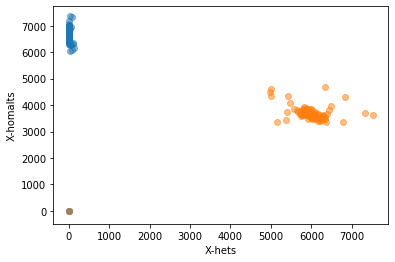

In [18]:
num_X_hets = np.sum(gen[:, coordinates[:, 0]==23]==1, axis=1)
num_X_homalts = np.sum(gen[:, coordinates[:, 0]==23]==2, axis=1)
plt.scatter(num_X_hets[[i for i, x in enumerate(individuals) if individual_to_sex[x]=='1']],
            num_X_homalts[[i for i, x in enumerate(individuals) if individual_to_sex[x]=='1']],
            label='male', alpha=0.5)
plt.scatter(num_X_hets[[i for i, x in enumerate(individuals) if individual_to_sex[x]=='2']],
            num_X_homalts[[i for i, x in enumerate(individuals) if individual_to_sex[x]=='2']],
            label='female', alpha=0.5)
plt.xlabel('X-hets')
plt.ylabel('X-homalts')
plt.show()

# Check relationships

In [19]:
moms, dads, childs = [], [], []
mom_indices, dad_indices, child_indices = [], [], []
for (mom, dad), children in parents_to_children.items():
    for child in children:
        if mom in individual_to_index and dad in individual_to_index and child in individual_to_index:
            mom_indices.append(individual_to_index[mom])
            dad_indices.append(individual_to_index[dad])
            child_indices.append(individual_to_index[child])
            
            moms.append(mom)
            dads.append(dad)
            childs.append(child)


(205, 649451)


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in true_divide


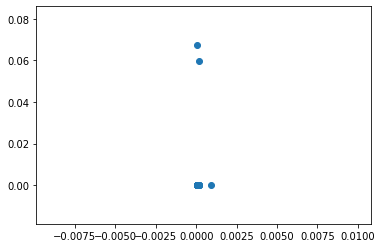

In [43]:
autosomal_gen = gen[:, coordinates[:, 0]<23]
print(autosomal_gen.shape)

num_mom_errors = np.sum((autosomal_gen[mom_indices, :]==0) & (autosomal_gen[child_indices, :]==2), axis=1)
num_mom_errors += np.sum((autosomal_gen[mom_indices, :]==2) & (autosomal_gen[child_indices, :]==0), axis=1)
num_mom_errors = num_mom_errors/np.sum((autosomal_gen[mom_indices, :]>=0) & (autosomal_gen[child_indices, :]>=0), axis=1)

num_dad_errors = np.sum((autosomal_gen[dad_indices, :]==0) & (autosomal_gen[child_indices, :]==2), axis=1)
num_dad_errors += np.sum((autosomal_gen[dad_indices, :]==2) & (autosomal_gen[child_indices, :]==0), axis=1)
num_dad_errors = num_dad_errors/np.sum((autosomal_gen[dad_indices, :]>=0) & (autosomal_gen[child_indices, :]>=0), axis=1)

plt.scatter(num_mom_errors, num_dad_errors)
plt.show()

In [44]:
num_sib_errors = []
num_unrelated_errors = []
for (mom, dad), children in parents_to_children.items():
    for child1, child2 in combinations(children, 2):
        if child1 in individual_to_index and child2 in individual_to_index:
            child1_index, child2_index = individual_to_index[child1], individual_to_index[child2]
            num_sib_err = np.sum((autosomal_gen[child1_index, :]==0) & (autosomal_gen[child2_index, :]==2))
            num_sib_err += np.sum((autosomal_gen[child1_index, :]==2) & (autosomal_gen[child2_index, :]==0))
            num_sib_errors.append(num_sib_err/np.sum((autosomal_gen[child1_index, :]>=0) & (autosomal_gen[child2_index, :]>=0)))
    if mom in individual_to_index and dad in individual_to_index:
        mom_index, dad_index = individual_to_index[mom], individual_to_index[dad]
        num_unrel_err = np.sum((autosomal_gen[mom_index, :]==0) & (autosomal_gen[dad_index, :]==2))
        num_unrel_err += np.sum((autosomal_gen[mom_index, :]==2) & (autosomal_gen[dad_index, :]==0))
        num_unrelated_errors.append(num_unrel_err/np.sum((autosomal_gen[mom_index, :]>=0) & (autosomal_gen[dad_index, :]>=0)))

num_sib_errors = np.array(num_sib_errors)
num_unrelated_errors = np.array(num_unrelated_errors)


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in long_scalars


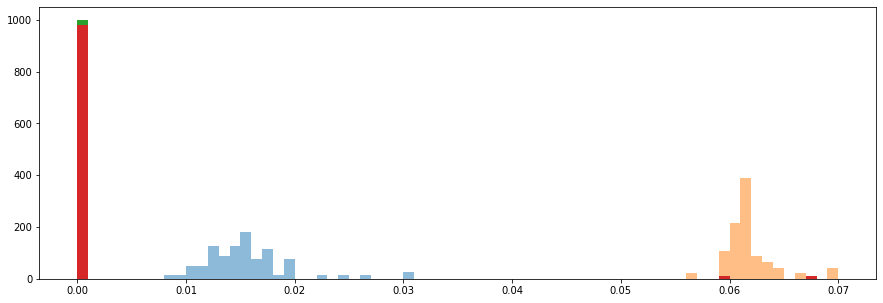

In [47]:
plt.figure(figsize=(15, 5))

plt.hist(np.clip(num_sib_errors, 0, 0.07), alpha=0.5, bins=np.arange(0, 0.071, 0.001), density=True)
plt.hist(np.clip(num_unrelated_errors, 0, 0.07), alpha=0.5, bins=np.arange(0, 0.071, 0.001), density=True)
plt.hist(np.clip(num_mom_errors, 0, 0.07), bins=np.arange(0, 0.071, 0.001), density=True)
plt.hist(np.clip(num_dad_errors, 0, 0.07), bins=np.arange(0, 0.071, 0.001), density=True)
plt.show()

In [49]:
print('moms')
print([moms[i] for i in np.where(num_mom_errors>0.01)[0]])
print([childs[i] for i in np.where(num_mom_errors>0.01)[0]])

print('dads')
print([dads[i] for i in np.where(num_dad_errors>0.01)[0]])
print([childs[i] for i in np.where(num_dad_errors>0.01)[0]])

moms
[]
[]
dads
['1152_DAD', '1461_DAD']
['1152_NT_1', '1461_ASD_2']


//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater


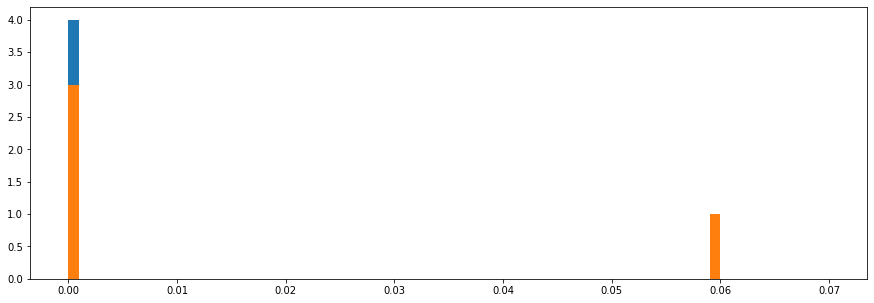

In [51]:
plt.figure(figsize=(15, 5))

plt.hist(np.clip(num_mom_errors[['1152' in mom for mom in moms]], 0, 0.07), bins=np.arange(0, 0.071, 0.001))
plt.hist(np.clip(num_dad_errors[['1152' in dad for dad in dads]], 0, 0.07), bins=np.arange(0, 0.071, 0.001))
plt.show()

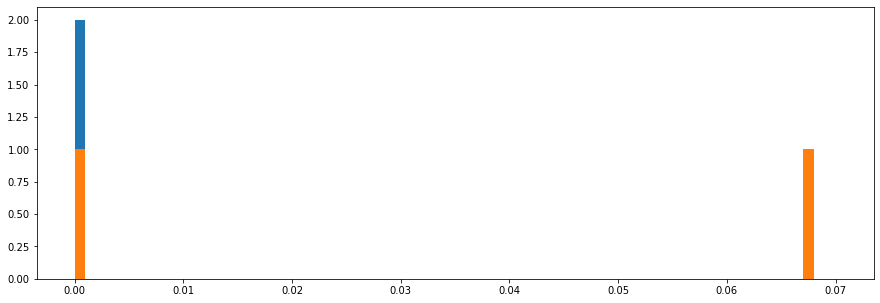

In [52]:
plt.figure(figsize=(15, 5))

plt.hist(np.clip(num_mom_errors[['1461' in mom for mom in moms]], 0, 0.07), bins=np.arange(0, 0.071, 0.001))
plt.hist(np.clip(num_dad_errors[['1461' in dad for dad in dads]], 0, 0.07), bins=np.arange(0, 0.071, 0.001))
plt.show()

In [ ]:
rels = list(combinations(individuals, 2))
num_errors = -np.ones((len(rels),))
for i, (ind1, ind2) in enumerate(rels):
    num_errors[i] = np.sum((autosomal_gen[indices, :][]==0) & (autosomal_gen[individual_to_index[ind2], :]==2))
    num_errors[i] += np.sum((autosomal_gen[individual_to_index[ind1], :]==2) & (autosomal_gen[individual_to_index[ind2], :]==0))
    

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(num_errors, bins=np.arange(0, 1, 0.01))
plt.show()

In [ ]:
print(num_errors[num_errors<0])